# Lab — Deep Graph Generative Models

### Mini graph classification dataset

In [1]:
#!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html -q
!pip install dgl -q

     |████████████████████████████████| 4.4 MB 31.7 MB/s 


In [2]:
import torch
from torch import nn
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

import dgl
from dgl.data import DGLDataset, MiniGCDataset
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv, AvgPooling

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

from IPython.display import clear_output

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
class OrderingGCD(MiniGCDataset):
    def process(self):
        self.full_adj = []
        super(OrderingGCD, self).process()
        for graph in tqdm(self.graphs):
            G1 = nx.Graph(graph.to_networkx())
            G2 = graph.to_networkx()

            degree = list(nx.degree_centrality(G1).values())
            betweenness = list(nx.betweenness_centrality(G1).values())
            closeness = list(nx.closeness_centrality(G1).values())
            eigenvector = list(nx.eigenvector_centrality(G1, max_iter=200).values())
            node_feat = torch.FloatTensor(
                np.vstack([degree, betweenness, closeness, eigenvector]).T
            )
            graph.ndata['feat'] = node_feat

            adj = graph.adj().to_dense()
            top_degree = adj.sum(dim=1).argmax()
            bfs_seq = dgl.bfs_nodes_generator(graph, top_degree)
            idx = torch.cat(bfs_seq)
            adj = adj[idx, :][:, idx]
            k = self.max_num_v - adj.shape[0]
            full_adj = F.pad(adj, (0, k, 0, k))
            full_adj = full_adj.reshape(1, self.max_num_v, self.max_num_v)
            
            self.full_adj.append(full_adj)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx], self.full_adj[idx]

In [4]:
graph_type = {
    0: 'cycle graph', 
    1: 'star graph', 
    2: 'wheel graph', 
    3: 'lollipop graph', 
    4: 'hypercube graph',
    5: 'grid graph',
    6: 'clique graph',
    7: 'circular ladder graph'
}

max_num_v = 12
dataset = OrderingGCD(
    num_graphs=800*2, 
    min_num_v=6, 
    max_num_v=max_num_v, 
    seed=0, 
    force_reload=True
)

  0%|          | 0/1600 [00:00<?, ?it/s]

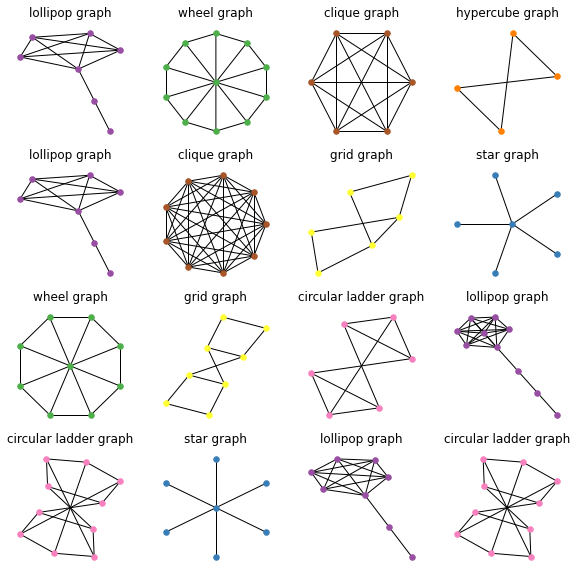

In [5]:
N = len(dataset)
plt.figure(figsize=(10, 10))
np.random.seed(0)
for i in range(16):
    plt.subplot(4, 4, i+1)
    g, l, adj = dataset[np.random.randint(N)]
    g = nx.Graph(g.to_networkx())
    g.remove_edges_from(nx.selfloop_edges(g))
    nx.draw_kamada_kawai(g, node_size=30, node_color=[plt.cm.Set1.colors[l.item()]])
    plt.title(graph_type[l.item()])

### GraphVAE

 Simonovsky and Komodakis [2018]

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/lab_deep_generation/graph_vae.png' width=800>

GCN encoder with graph pooling

In [ ]:
class GaussianGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv = GraphConv(input_dim, hidden_dim)
        self.mu = GraphConv(hidden_dim, output_dim)
        self.sigma = GraphConv(hidden_dim, output_dim)
        self.pooling = AvgPooling()

    def forward(self, g, features):
        h = self.conv(g, features)
        h = F.relu(h)
        mu = self.mu(g, h)
        sigma = F.softplus(self.sigma(g, h))
        return self.pooling(g, mu), self.pooling(g, sigma)

In [ ]:
graph, label, adj = dataset[0]

In [ ]:
encoder = GaussianGCN(input_dim=4, hidden_dim=256, output_dim=128)
z_mu, z_sigma = encoder(graph, graph.ndata['feat'])
z_mu.shape, z_sigma.shape

(torch.Size([1, 128]), torch.Size([1, 128]))

Probabilistic fully-connected graph decoder

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        self.MLP = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_nodes**2),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.MLP(x)
        return x.reshape(-1, self.n_nodes, self.n_nodes)

In [ ]:
decoder = MLP(input_dim=128, hidden_dim=256, n_nodes=max_num_v)
pred_adj = decoder(z_mu)
pred_adj = pred_adj[0]
pred_adj.shape

torch.Size([12, 12])

### BFS heuristic graph matching

In [ ]:
graph, label, _ = dataset[302*2]

'lollipop graph'

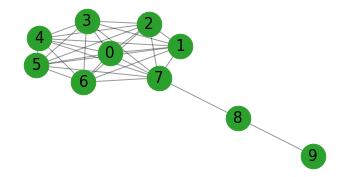

In [ ]:
plt.figure(figsize=(6, 3))
G = nx.Graph(graph.to_networkx())
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='tab:green')
nx.draw_networkx_labels(G, pos, font_size=15)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.axis('off')
graph_type[label.item()]

In [ ]:
adj = graph.adj().to_dense()
top_degree = adj.sum(dim=1).argmax()
bfs_seq = dgl.bfs_nodes_generator(graph, top_degree)
bfs_seq

(tensor([7]), tensor([0, 1, 2, 3, 4, 5, 6, 8]), tensor([9]))

In [ ]:
idx = torch.cat(bfs_seq)
idx

tensor([7, 0, 1, 2, 3, 4, 5, 6, 8, 9])

In [ ]:
print(adj.numpy().astype('int'))

[[1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1]]


In [ ]:
print(adj[idx, :][:, idx].numpy().astype('int'))

[[1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1]]


In [ ]:
print(pred_adj.detach().numpy().round(2))

[[0.5  0.5  0.5  0.48 0.52 0.51 0.49 0.48 0.5  0.51 0.48 0.51]
 [0.51 0.5  0.51 0.51 0.5  0.53 0.48 0.51 0.51 0.5  0.51 0.5 ]
 [0.51 0.51 0.52 0.48 0.5  0.47 0.52 0.5  0.51 0.5  0.49 0.51]
 [0.5  0.5  0.51 0.48 0.49 0.48 0.52 0.5  0.51 0.52 0.5  0.5 ]
 [0.52 0.5  0.5  0.5  0.49 0.52 0.5  0.51 0.51 0.51 0.5  0.5 ]
 [0.49 0.5  0.51 0.47 0.5  0.49 0.49 0.49 0.49 0.5  0.51 0.5 ]
 [0.48 0.49 0.49 0.51 0.5  0.49 0.51 0.5  0.49 0.51 0.48 0.52]
 [0.51 0.51 0.49 0.51 0.5  0.51 0.48 0.49 0.52 0.49 0.49 0.5 ]
 [0.5  0.5  0.5  0.51 0.52 0.51 0.5  0.51 0.51 0.49 0.51 0.51]
 [0.5  0.49 0.51 0.5  0.49 0.5  0.5  0.49 0.52 0.49 0.5  0.5 ]
 [0.5  0.49 0.49 0.51 0.49 0.51 0.48 0.51 0.49 0.5  0.52 0.49]
 [0.49 0.49 0.52 0.51 0.49 0.5  0.51 0.48 0.51 0.49 0.51 0.51]]


In [ ]:
_adj = (pred_adj > 0.5).type(torch.LongTensor)
_adj

tensor([[1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1]])

In [ ]:
mask = _adj.diagonal() == 0
mask

tensor([False, False, False,  True,  True,  True, False,  True, False,  True,
        False, False])

In [ ]:
_adj = (pred_adj > 0.5).type(torch.LongTensor)
_adj[mask, :] = 0
_adj[:, mask] = 0
_adj

tensor([[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]])

In [ ]:
edges = np.nonzero(_adj)
gen_g = dgl.graph((edges[:, 0], edges[:, 1]))
top_degree = _adj.sum(dim=1).argmax()
bfs_seq = dgl.bfs_nodes_generator(gen_g, top_degree)
idx = torch.cat(bfs_seq)
if len(idx) < max_num_v:
    _idx = [i for i in torch.arange(max_num_v) if i not in idx]
    _idx = torch.tensor(_idx)
    idx = torch.cat([idx, _idx])
idx

tensor([ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9])

In [ ]:
print(pred_adj[idx, :][:, idx].detach().numpy().round(2))

[[0.5  0.51 0.51 0.51 0.51 0.5  0.48 0.51 0.5  0.53 0.51 0.5 ]
 [0.5  0.5  0.5  0.5  0.48 0.51 0.49 0.48 0.52 0.51 0.48 0.51]
 [0.51 0.51 0.52 0.51 0.49 0.51 0.52 0.48 0.5  0.47 0.5  0.5 ]
 [0.5  0.5  0.5  0.51 0.51 0.51 0.5  0.51 0.52 0.51 0.51 0.49]
 [0.49 0.5  0.49 0.49 0.52 0.49 0.48 0.51 0.49 0.51 0.51 0.5 ]
 [0.49 0.49 0.52 0.51 0.51 0.51 0.51 0.51 0.49 0.5  0.48 0.49]
 [0.49 0.48 0.49 0.49 0.48 0.52 0.51 0.51 0.5  0.49 0.5  0.51]
 [0.5  0.5  0.51 0.51 0.5  0.5  0.52 0.48 0.49 0.48 0.5  0.52]
 [0.5  0.52 0.5  0.51 0.5  0.5  0.5  0.5  0.49 0.52 0.51 0.51]
 [0.5  0.49 0.51 0.49 0.51 0.5  0.49 0.47 0.5  0.49 0.49 0.5 ]
 [0.51 0.51 0.49 0.52 0.49 0.5  0.48 0.51 0.5  0.51 0.49 0.49]
 [0.49 0.5  0.51 0.52 0.5  0.5  0.5  0.5  0.49 0.5  0.49 0.49]]


In [ ]:
pred_adj.shape, adj.shape

(torch.Size([12, 12]), torch.Size([10, 10]))

In [ ]:
k = max_num_v - adj.shape[0]
full_adj = F.pad(adj, (0, k, 0, k))
full_adj, full_adj.shape

(tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([12, 12]))

### Batch BFS ordering



In [ ]:
def batch_bfs_ordering(pred_batch):
    ordering = []
    for _pred_adj in pred_batch:
        pred_adj = _pred_adj
        _adj = (pred_adj > 0.5).type(torch.LongTensor)
        mask = _adj.diagonal() == 0
        _adj[mask, :] = 0
        _adj[:, mask] = 0
        edges = np.nonzero(_adj)
        gen_g = dgl.graph((edges[:, 0], edges[:, 1]))
        top_degree = _adj.sum(dim=1).argmax()
        bfs_seq = dgl.bfs_nodes_generator(gen_g, top_degree)
        idx = torch.cat(bfs_seq)
        if len(idx) < max_num_v:
            _idx = [i for i in torch.arange(max_num_v) if i not in idx]
            _idx = torch.tensor(_idx)
            idx = torch.cat([idx, _idx])
        ordering.append(idx.reshape(1, -1))
    return torch.cat(ordering, dim=0)

In [ ]:
graph, label, full_adj = dataset[0]

In [ ]:
batch_size = 2
g_batch = dgl.batch([graph, graph])
z_mu, z_sigma = encoder(g_batch, g_batch.ndata['feat'])
pred_batch = decoder(z_mu)
batch_ordering = batch_bfs_ordering(pred_batch)
batch_ordering

tensor([[ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
        [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9]])

In [ ]:
batch_size = 2
batch_idx = torch.arange(batch_size).reshape(-1, 1, 1)
batch_idx = batch_idx.repeat(1, max_num_v, max_num_v)
batch_idx

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1

In [ ]:
row_idx = batch_ordering[:, None, :].repeat(1, max_num_v, 1)
row_idx

tensor([[[ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9]],

        [[ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7,  9],
         [ 1,  0,  2,  8, 10, 11,  6,  3,  4,  5,  7, 

In [ ]:
col_idx = batch_ordering[:, :, None].repeat(1, 1, max_num_v)
col_idx

tensor([[[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
         [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
         [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
         [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
         [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
         [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
         [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
         [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9]],

        [[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
         [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

In [ ]:
print(pred_batch[batch_idx, row_idx, col_idx].detach().numpy().round(2))

[[[0.5  0.5  0.51 0.5  0.49 0.49 0.49 0.5  0.5  0.5  0.51 0.49]
  [0.51 0.5  0.51 0.5  0.5  0.49 0.48 0.5  0.52 0.49 0.51 0.5 ]
  [0.51 0.5  0.52 0.5  0.49 0.52 0.49 0.51 0.5  0.51 0.49 0.51]
  [0.51 0.5  0.51 0.51 0.49 0.51 0.49 0.51 0.51 0.49 0.52 0.52]
  [0.51 0.48 0.49 0.51 0.52 0.51 0.48 0.5  0.5  0.51 0.49 0.5 ]
  [0.5  0.51 0.51 0.51 0.49 0.51 0.52 0.5  0.5  0.5  0.5  0.5 ]
  [0.48 0.49 0.52 0.5  0.48 0.51 0.51 0.52 0.5  0.49 0.48 0.5 ]
  [0.51 0.48 0.48 0.51 0.51 0.51 0.51 0.48 0.5  0.47 0.51 0.5 ]
  [0.5  0.52 0.5  0.52 0.49 0.49 0.5  0.49 0.49 0.5  0.5  0.49]
  [0.53 0.51 0.47 0.51 0.51 0.5  0.49 0.48 0.52 0.49 0.51 0.5 ]
  [0.51 0.48 0.5  0.51 0.51 0.48 0.5  0.5  0.51 0.49 0.49 0.49]
  [0.5  0.51 0.5  0.49 0.5  0.49 0.51 0.52 0.51 0.5  0.49 0.49]]

 [[0.5  0.5  0.51 0.5  0.49 0.49 0.49 0.5  0.5  0.5  0.51 0.49]
  [0.51 0.5  0.51 0.5  0.5  0.49 0.48 0.5  0.52 0.49 0.51 0.5 ]
  [0.51 0.5  0.52 0.5  0.49 0.52 0.49 0.51 0.5  0.51 0.49 0.51]
  [0.51 0.5  0.51 0.51 0.49 0.51 0.49 

In [ ]:
batch_full_adj = torch.cat([full_adj, full_adj], dim=0)
batch_full_adj.shape

torch.Size([2, 12, 12])

In [ ]:
F.binary_cross_entropy(pred_batch[batch_idx, row_idx, col_idx], batch_full_adj)

tensor(0.6944, grad_fn=<BinaryCrossEntropyBackward0>)

### Negative ELBO loss

In [ ]:
def neg_elbo(pred_adj, adj, sigma, mu, batch_size):
    likelihood = -F.binary_cross_entropy(pred_adj, adj)
    d_kl = -(1 + torch.log(sigma**2) - mu**2 - sigma**2) * 0.5 / batch_size
    d_kl = d_kl.sum(1).mean()
    elbo = likelihood - d_kl
    return -elbo

In [ ]:
batch_full_adj = torch.cat([full_adj, full_adj], dim=0)

batch = dgl.batch([graph, graph])
z_mu, z_sigma = encoder(batch, batch.ndata['feat'])
pred_batch = decoder(z_mu)
batch_ordering = batch_bfs_ordering(pred_batch)
batch_idx = torch.arange(2).reshape(-1, 1, 1)
batch_idx = batch_idx.repeat(1, max_num_v, max_num_v)
row_idx = batch_ordering[:, None, :].repeat(1, max_num_v, 1)
col_idx = batch_ordering[:, :, None].repeat(1, 1, max_num_v)
neg_elbo(pred_batch[batch_idx, row_idx, col_idx], batch_full_adj, z_sigma, z_mu, 2)

tensor(7.6342, grad_fn=<NegBackward0>)

### Train test split

In [11]:
np.random.seed(0)
ratio = [0.9, 0.1] # train test ratio
split_idx = ['train'] * int(ratio[0] * N) \
    + ['test'] * int(ratio[1] * N)
split_idx = np.random.permutation(split_idx)
train_idx = np.where(split_idx == 'train')[0]
test_idx = np.where(split_idx == 'test')[0]

train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)

In [12]:
def collate(sample):
    graphs, labels, full_adj = map(list, zip(*sample))
    graph = dgl.batch(graphs)
    labels = torch.tensor(labels)
    full_adj = torch.cat(full_adj)
    return graph, labels, full_adj

batch_size = 32
train_dataloader = DataLoader(
    train_set, batch_size=batch_size, drop_last=True, collate_fn=collate, shuffle=True)
test_dataloader = DataLoader(
    test_set, batch_size=batch_size, drop_last=False, collate_fn=collate)

### Train model

In [ ]:
def train(encoder, decoder, dataloader, opt, batch_size, emb_dim, batch_idx):
    encoder.train()
    decoder.train()
    _train_loss = []
    for graph, label, full_adj in dataloader:
        mu, sigma = encoder(graph, graph.ndata['feat'])
        z = torch.randn(batch_size, emb_dim)
        z = z * sigma + mu
        pred_adj = decoder(z)
        ord = batch_bfs_ordering(pred_adj)
        row_idx = ord[:, None, :].repeat(1, max_num_v, 1)
        col_idx = ord[:, :, None].repeat(1, 1, max_num_v)
        loss = neg_elbo(pred_adj[batch_idx, row_idx, col_idx], full_adj, sigma, mu, batch_size)

        opt.zero_grad()
        loss.backward()
        opt.step()
        _train_loss.append(loss.item())
    return sum(_train_loss) / len(_train_loss)

In [ ]:
emb_dim = 32
encoder = GaussianGCN(input_dim=4, hidden_dim=256, output_dim=emb_dim)
decoder = MLP(input_dim=emb_dim, hidden_dim=256, n_nodes=max_num_v)
params = list(encoder.parameters()) + list(decoder.parameters())
opt = Adam(params, lr=0.005)
batch_idx = torch.arange(batch_size).reshape(-1, 1, 1)
batch_idx = batch_idx.repeat(1, max_num_v, max_num_v)

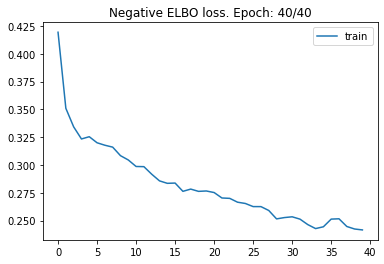

In [ ]:
n_epochs = 40
train_loss = []
for epoch in range(n_epochs):
    loss = train(encoder, decoder, train_dataloader, opt, batch_size, emb_dim, batch_idx)
    train_loss.append(loss)
    plt.plot(train_loss[-50:], label='train')
    plt.legend()
    plt.title('Negative ELBO loss. Epoch: {}/{}'.format(epoch+1, n_epochs))
    plt.show()
    clear_output(wait=True)

### Graph generation

In [ ]:
def generate_adj(batch):
    adjs = []
    for pred_adj in batch:
        _adj = (pred_adj > 0.5).type(torch.LongTensor)
        mask = _adj.diagonal() == 0
        _adj[mask, :] = 0
        _adj[:, mask] = 0
        edges = np.nonzero(_adj)
        gen_g = dgl.graph((edges[:, 0], edges[:, 1]))
        top_degree = _adj.sum(dim=1).argmax()
        bfs_seq = dgl.bfs_nodes_generator(gen_g, top_degree)
        idx = torch.cat(bfs_seq)
        adjs.append(_adj[idx, :][:, idx])
    return adjs

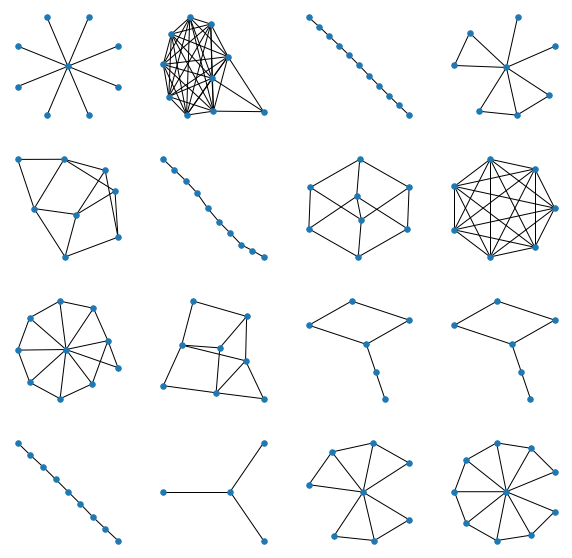

In [ ]:
plt.figure(figsize=(10, 10))
z = torch.randn(16, emb_dim)
decoder.eval()
with torch.no_grad():
    pred_adj = decoder(z)
gen_adj = generate_adj(pred_adj)
for i in range(16):
    plt.subplot(4, 4, i+1)
    G = nx.from_numpy_array(gen_adj[i].numpy())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)

### Graph embedding

In [ ]:
batch = dgl.batch([graph for graph, label, full_adj in test_set])
y = np.array([label.item() for graph, label, full_adj in test_set])
with torch.no_grad():
    encoder.eval()
    z_mu, z_sigma = encoder(batch, batch.ndata['feat'])

In [ ]:
reduction = TSNE(n_components=2)
xy_emb = reduction.fit_transform(z_mu)

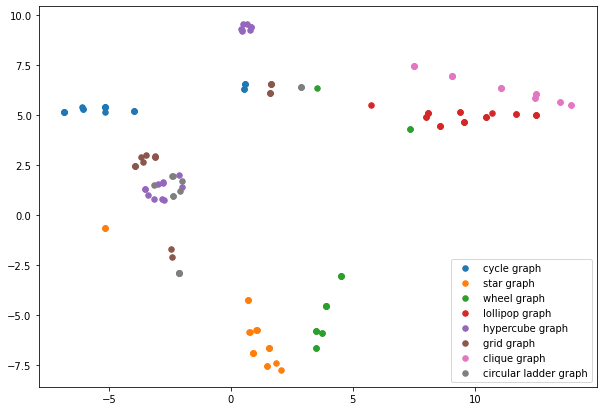

In [ ]:
plt.figure(figsize=(10, 7))
for i, g_type in graph_type.items():
    plt.scatter(xy_emb[y==i, 0], xy_emb[y==i, 1], s=30, label=g_type)
plt.legend()
plt.show()

### Graph GAN

by De Cao and Kipf [2018]

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/lab_deep_generation/graph_gan.png' width=800>

In [13]:
max_num_v = 12
dataset = OrderingGCD(
    num_graphs=800*2, 
    min_num_v=10, 
    max_num_v=max_num_v, 
    seed=0, 
    force_reload=True
)
dataset = Subset(dataset, np.arange(300*2, 400*2))

  0%|          | 0/1600 [00:00<?, ?it/s]

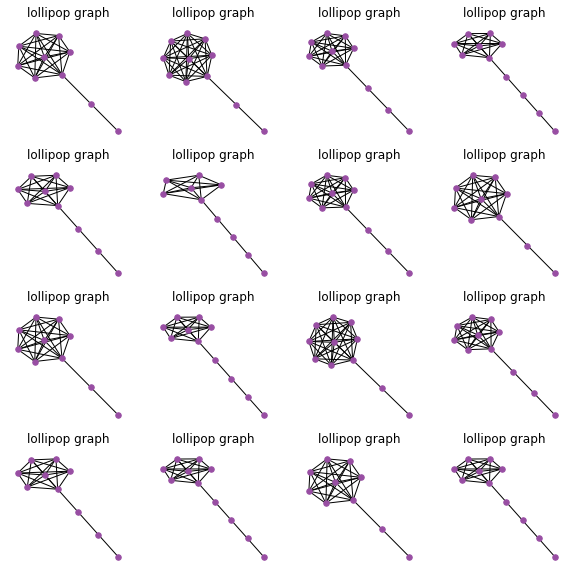

In [14]:
N = len(dataset)
plt.figure(figsize=(10, 10))
np.random.seed(0)
for i in range(16):
    plt.subplot(4, 4, i+1)
    g, l, adj = dataset[np.random.randint(N)]
    g = nx.Graph(g.to_networkx())
    g.remove_edges_from(nx.selfloop_edges(g))
    nx.draw_kamada_kawai(g, node_size=30, node_color=[plt.cm.Set1.colors[l.item()]])
    plt.title(graph_type[l.item()])

In [15]:
batch_size = 32
train_dataloader = DataLoader(
    dataset, batch_size=batch_size, drop_last=True, collate_fn=collate, shuffle=True)

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        self.output_dim = output_dim
        self.dense = nn.Linear(input_dim, hidden_dim)
        self.dense_adj = nn.Linear(hidden_dim, n_nodes**2)
        self.dense_feat = nn.Linear(hidden_dim, n_nodes*output_dim)

    def forward(self, x):
        x = F.relu(self.dense(x))
        adj = torch.sigmoid(self.dense_adj(x))
        adj = adj.reshape(-1, self.n_nodes, self.n_nodes)
        feat = self.dense_feat(x).reshape(-1, self.n_nodes, self.output_dim)
        return adj, feat

In [17]:
class PoolingGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, adj, feat):
        D = torch.diag_embed(1 / torch.sqrt(adj.sum(dim=1)))
        L = D @ adj @ D
        h = L @ self.dense1(feat)
        h = F.relu(h)
        h = L @ self.dense2(h)
        return h.mean(dim=1)

In [18]:
disc = PoolingGCN(input_dim=4, hidden_dim=256, output_dim=1)

adj = torch.rand(2, 10, 10)
feat = torch.rand(2, 10, 4)
disc(adj, feat)

tensor([[0.1712],
        [0.1762]], grad_fn=<MeanBackward1>)

In [19]:
gen = MLP(input_dim=emb_dim, hidden_dim=256, output_dim=4, n_nodes=max_num_v)

z = torch.randn(batch_size, emb_dim)
fake_adj, fake_feat = gen(z)
fake_adj.shape, fake_feat.shape

(torch.Size([32, 12, 12]), torch.Size([32, 12, 4]))

In [20]:
disc(fake_adj, fake_feat).shape

torch.Size([32, 1])

In [143]:
def train(dataloader, gen, disc, gen_opt, disc_opt, batch_size, emb_dim):
    gen.train()
    disc.train()
    _gen_loss = []
    _disc_loss = []
    for real_graph, label, real_adj in dataloader:

        features = []
        adjacency = []
        for g in dgl.unbatch(real_graph):
            k = max_num_v - g.number_of_nodes()
            features.append(F.pad(g.ndata['feat'], (0, 0, 0, k))[None, ...])
            adjacency.append(F.pad(g.adj().to_dense(), (0, k, 0, k))[None, ...])
        real_adj = torch.cat(adjacency)
        real_adj[:, range(max_num_v), range(max_num_v)] = 1
        real_feat = torch.cat(features)
        
        z = torch.randn(batch_size, emb_dim)
        fake_adj, fake_feat = gen(z)
        fake_adj = fake_adj.round()
        mask = fake_adj.diagonal(dim1=1, dim2=2) == 1
        row_mask = mask[:, None, :].repeat(1, max_num_v, 1)
        col_mask = mask[:, :, None].repeat(1, 1, max_num_v)
        fake_adj = fake_adj * row_mask * col_mask
        fake_adj[:, range(max_num_v), range(max_num_v)] = 1

        term1 = F.binary_cross_entropy_with_logits(
            disc(real_adj, real_feat), torch.ones(batch_size, 1))
        term2 = F.binary_cross_entropy_with_logits(
            disc(fake_adj, fake_feat), torch.zeros(batch_size, 1))
        disc_loss = term1 + term2

        disc_opt.zero_grad()
        disc_loss.backward()
        disc_opt.step()

        z = torch.randn(batch_size, emb_dim)
        fake_adj, fake_feat = gen(z)
        fake_adj = fake_adj.round()
        mask = fake_adj.diagonal(dim1=1, dim2=2) == 1
        row_mask = mask[:, None, :].repeat(1, max_num_v, 1)
        col_mask = mask[:, :, None].repeat(1, 1, max_num_v)
        fake_adj = fake_adj * row_mask * col_mask
        fake_adj[:, range(max_num_v), range(max_num_v)] = 1

        gen_loss = F.binary_cross_entropy_with_logits(
            disc(fake_adj, fake_feat), torch.ones(batch_size, 1))

        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()
        
        _disc_loss.append(disc_loss.item())
        _gen_loss.append(gen_loss.item())

    return sum(_gen_loss)/len(_gen_loss), sum(_disc_loss)/len(_disc_loss)

In [144]:
def generate_adj(batch):
    adjs = []
    for pred_adj in batch:
        _adj = (pred_adj > 0.5).type(torch.LongTensor)
        mask = _adj.diagonal() == 0
        _adj[mask, :] = 0
        _adj[:, mask] = 0
        if torch.all(mask):
            adjs.append(_adj)
        else:
            edges = np.nonzero(_adj)
            gen_g = dgl.graph((edges[:, 0], edges[:, 1]))
            top_degree = _adj.sum(dim=1).argmax()
            bfs_seq = dgl.bfs_nodes_generator(gen_g, top_degree)
            idx = torch.cat(bfs_seq)
            adjs.append(_adj[idx, :][:, idx])
    return adjs

In [145]:
emb_dim = 32
gen = MLP(input_dim=emb_dim, hidden_dim=512, output_dim=4, n_nodes=max_num_v)
disc = PoolingGCN(input_dim=4, hidden_dim=256, output_dim=1)

In [154]:
gen_opt = Adam(gen.parameters(), lr=0.0001)
disc_opt = Adam(disc.parameters(), lr=0.0005)

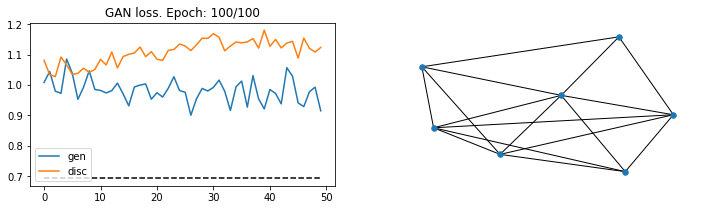

In [155]:
n_epochs = 100
gen_loss = []
disc_loss = []
for epoch in range(n_epochs):
    g_loss, d_loss = train(train_dataloader, gen, disc, gen_opt, disc_opt, batch_size, emb_dim)
    gen_loss.append(g_loss)
    disc_loss.append(d_loss)

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(gen_loss[-50:], label='gen')
    plt.plot(disc_loss[-50:], label='disc')
    plt.legend()
    plt.title('GAN loss. Epoch: {}/{}'.format(epoch+1, n_epochs))
    plt.hlines(-np.log(0.5), 0, min(50, len(gen_loss)) - 1, linestyles='--')
    plt.subplot(1, 2, 2)
    z = torch.randn(1, emb_dim)
    gen.eval()
    with torch.no_grad():
        fake_adj, fake_feat = gen(z)
    gen_adj = generate_adj(fake_adj)
    G = nx.from_numpy_array(gen_adj[0].numpy())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)
    plt.show()
    clear_output(wait=True)

### Graph generation

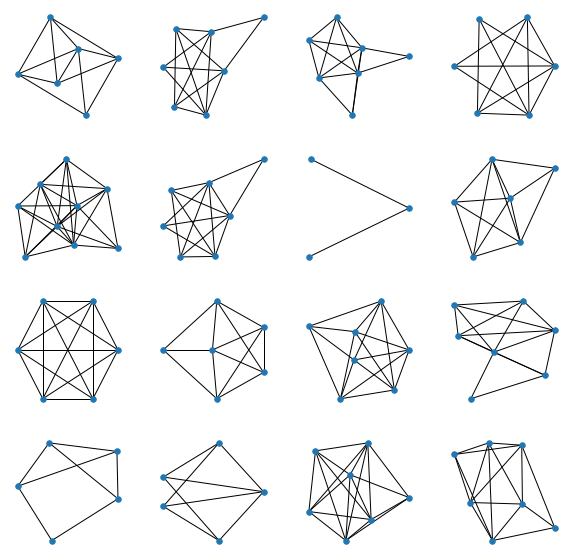

In [156]:
plt.figure(figsize=(10, 10))
z = torch.randn(batch_size, emb_dim)
gen.eval()
with torch.no_grad():
    fake_adj, fake_feat = gen(z)
gen_adj = generate_adj(fake_adj)
for i in range(16):
    plt.subplot(4, 4, i+1)
    G = nx.from_numpy_array(gen_adj[i].numpy())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)